# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

You should consider upgrading via the '/pfs/work9/workspace/scratch/ma_okadam-CLIP_EXP/CLIP_0/bin/python3 -m pip install --upgrade pip' command.
  Cloning https://github.com/openai/CLIP.git to /scratch/pip-req-build-wabgvvev
  Running command git clone -q https://github.com/openai/CLIP.git /scratch/pip-req-build-wabgvvev
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
You should consider upgrading via the '/pfs/work9/workspace/scratch/ma_okadam-CLIP_EXP/CLIP_0/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu118


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### Using the Resnet101 model

In [4]:
model, preprocess = clip.load("RN101")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 278M/278M [00:53<00:00, 5.41MiB/s]


Model parameters: 119,688,033
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x14fbb91bba60>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("This is my experiment with CLIP")

tensor([[49406,   589,   533,   607, 13079,   593,  9289, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Descriptions
descriptions = {
    "book": "An open book",
    "guitar_clean": "Picture of a guitar",
    "jetfighter": "F16 jet fighter",
    "submarine": "Submarine cruising in the ocean",
    "tank": "Modern Heavy Tank",
}

image_dir = "Images"
images = []

# Load and preprocess images
for filename in os.listdir(image_dir):
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
    image_tensor = preprocess(image)  # shape [3, 224, 224]
    images.append(image_tensor)

# Stack and send to device
image_input = torch.stack(images).to(device)

# Tokenize the text
text_tokens = clip.tokenize(["This is " + desc for desc in descriptions.values()]).to(device)
plt.show()

In [8]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


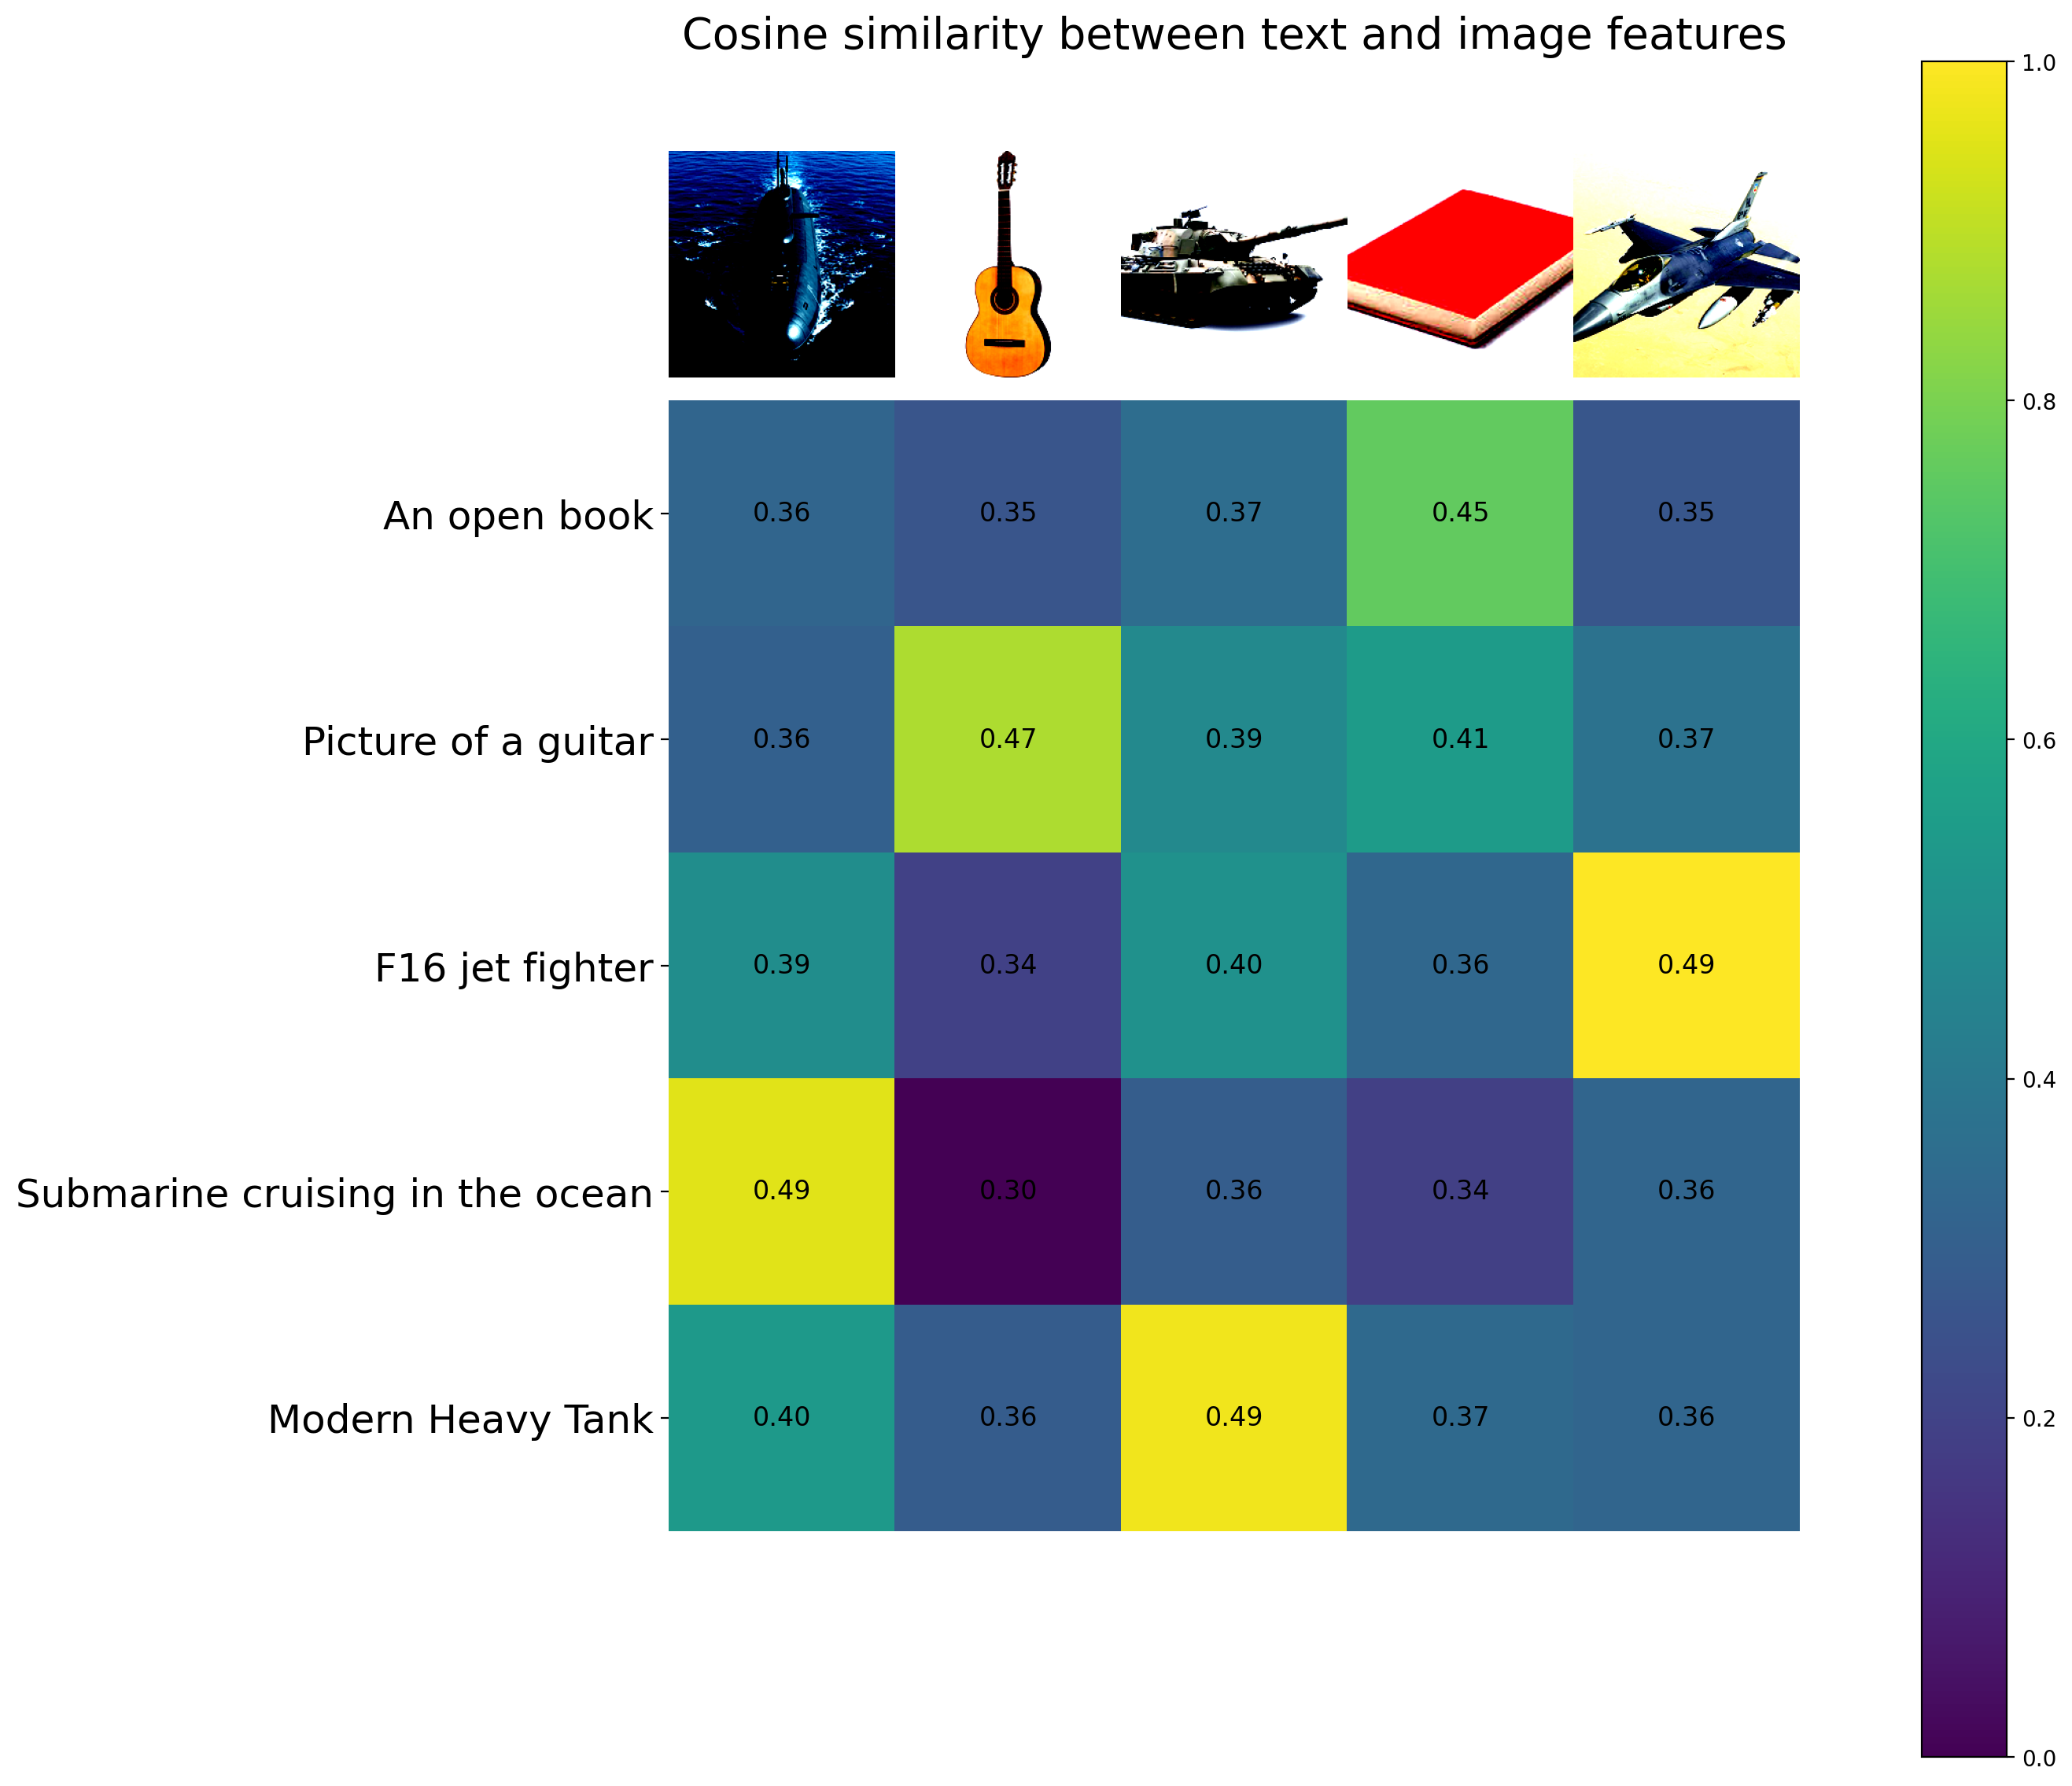

In [10]:
# Plotting similarity matrix
plt.figure(figsize=(20, 14))
plt.imshow(similarity, cmap="viridis")

count = len(descriptions)

plt.yticks(range(count), list(descriptions.values()), fontsize=18)
plt.xticks([])

for i, image_tensor in enumerate(images):
    # Convert tensor to numpy and transpose to (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np, 0, 1)  # In case of normalization
    plt.imshow(image_np, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add similarity score text
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# Remove borders
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.colorbar()
plt.show()


In [11]:
from torchvision.datasets import CIFAR10

# Download CIFAR100 class names (no need to load the actual images)
cifar = CIFAR10(os.path.expanduser("~/.cache"), download=True)

# Create prompt sentences like "This is a photo of a ... "
text_descriptions = [f"This is a photo of a {label}" for label in cifar.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode the text prompts with CLIP
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [12]:
# Encode image features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

# Compute similarity scores (logits)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)  # [N, 100]

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9468161].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7630657..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520971..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


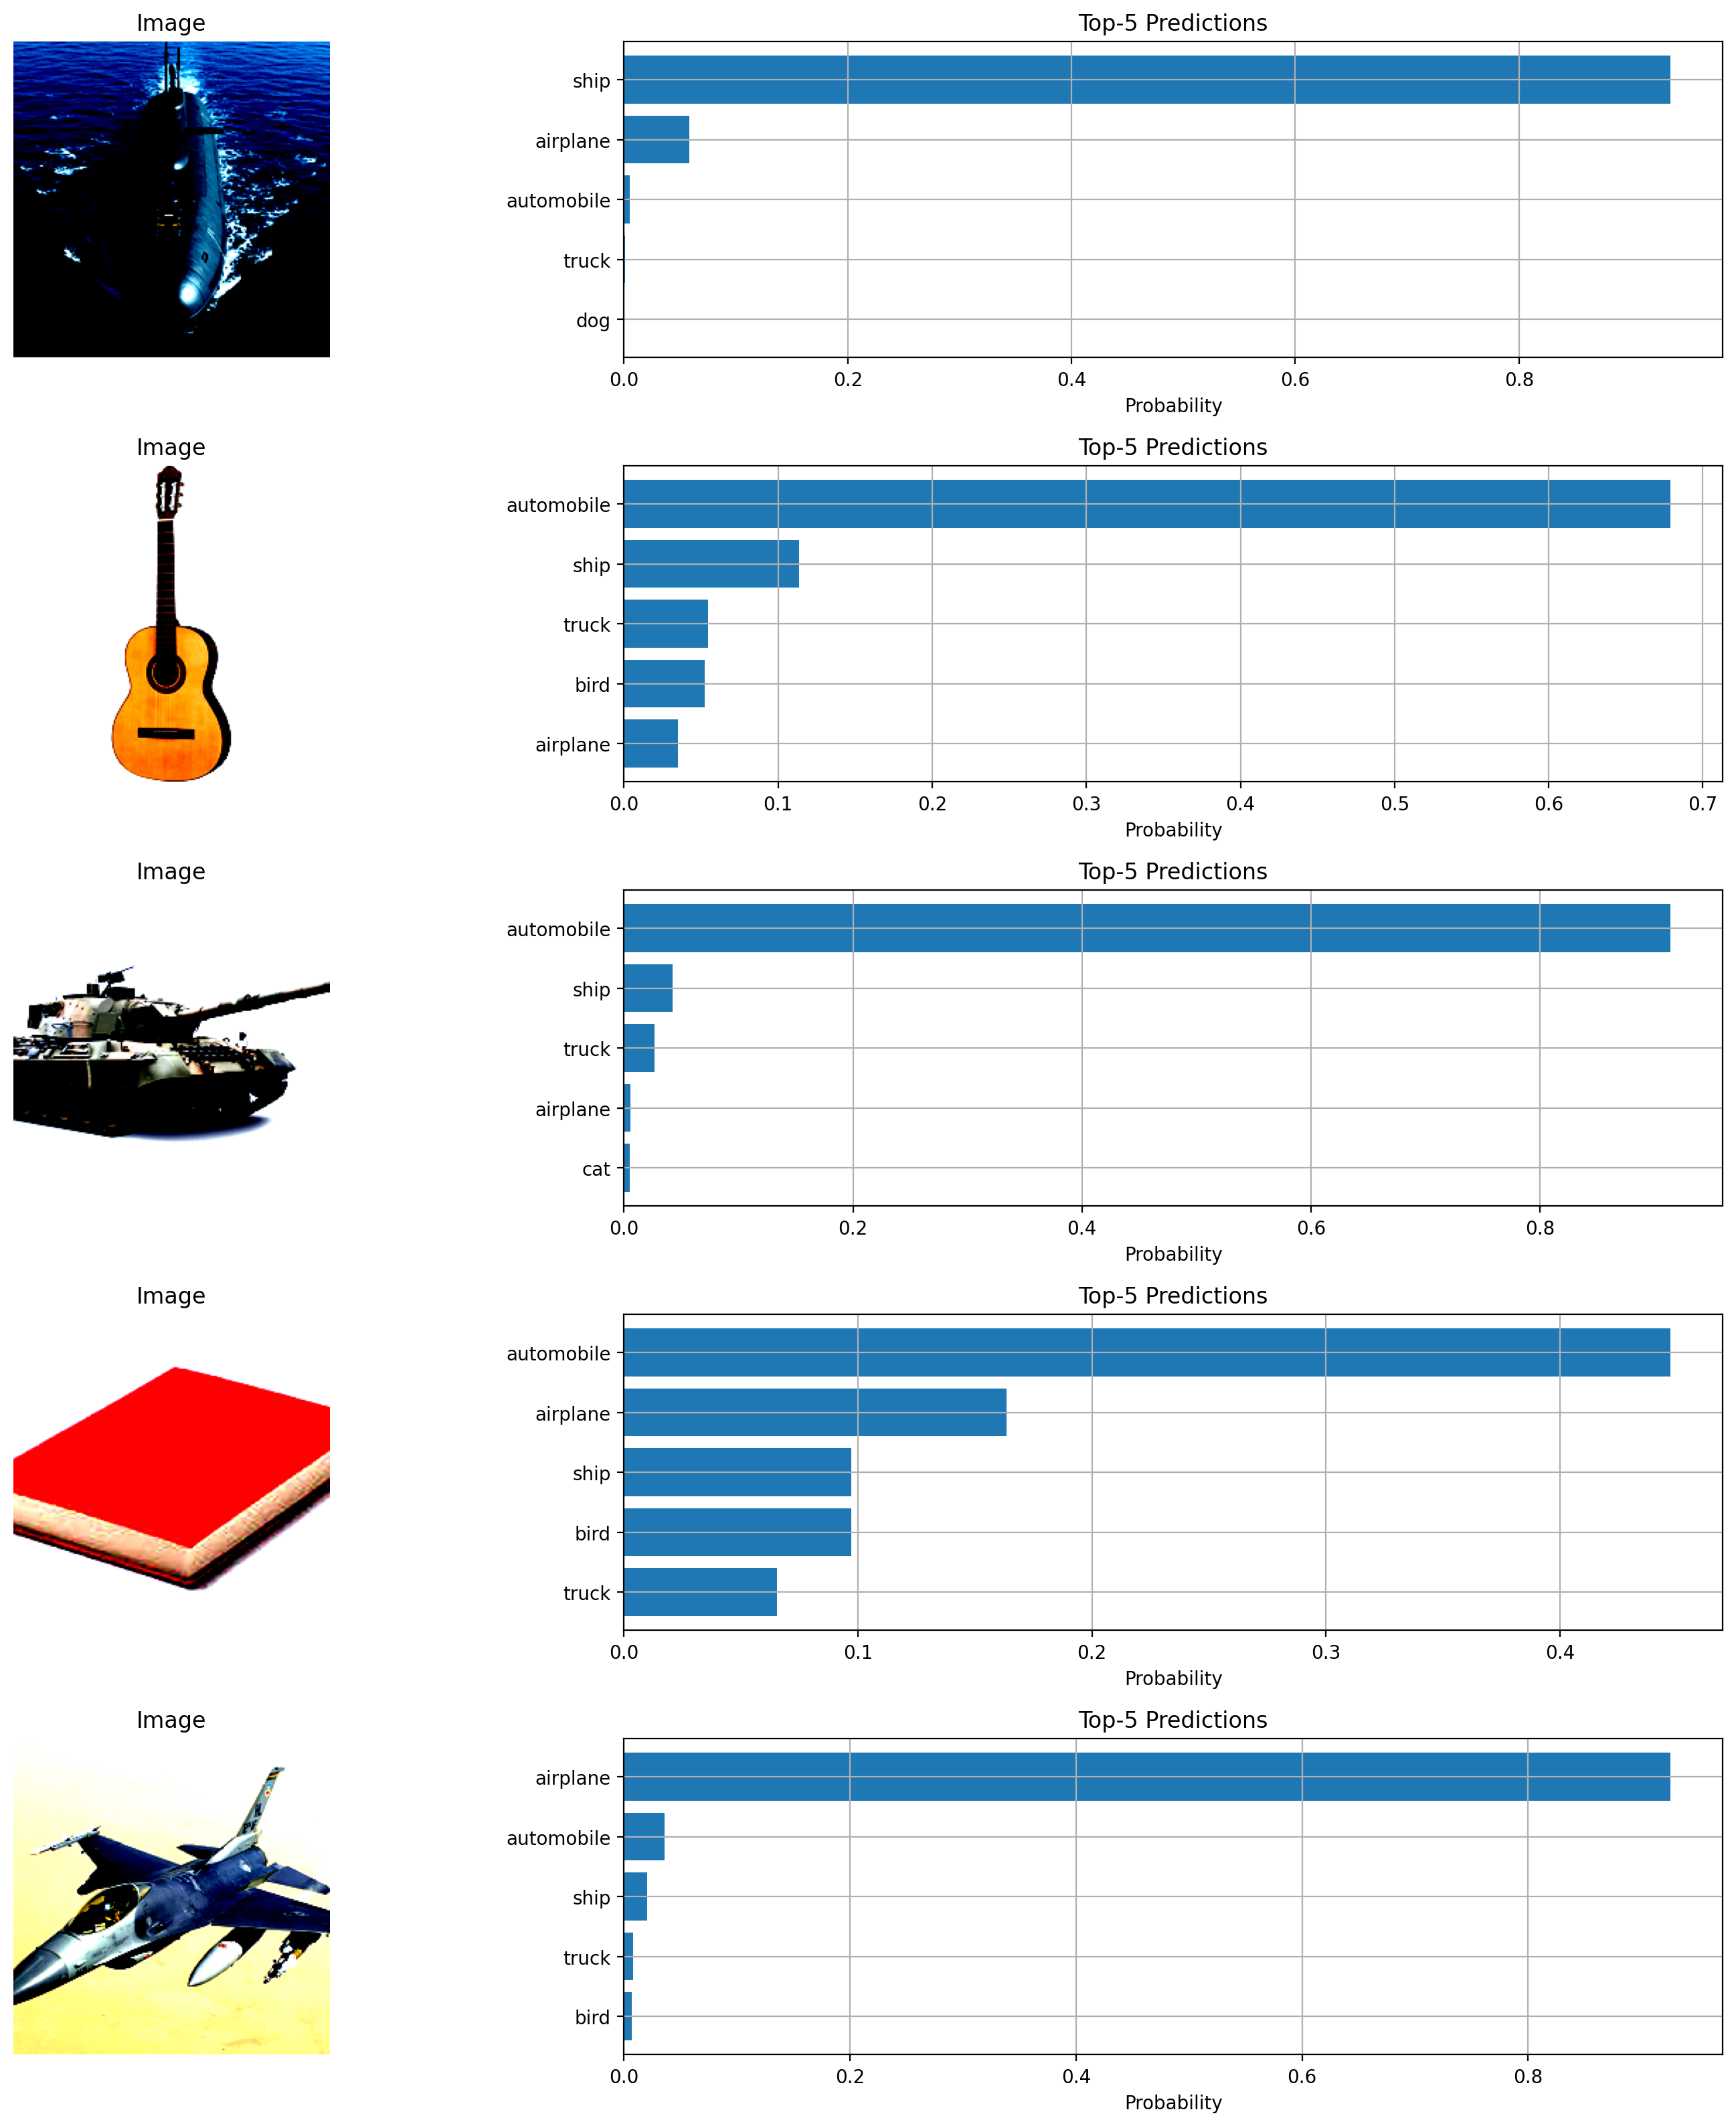

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    # Show image
    plt.subplot(len(images), 2, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Image", fontsize=12)

    # Show bar plot of top-5 predictions
    plt.subplot(len(images), 2, 2 * i + 2)
    y = np.arange(5)
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.yticks(y, [cifar.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("Probability")
    plt.title("Top-5 Predictions", fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()
